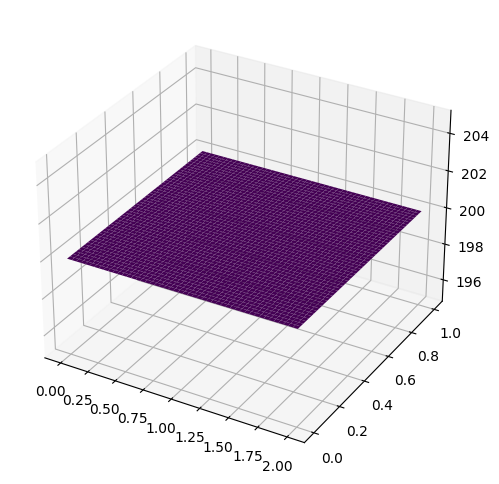

In [3]:
import numpy as np
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation

# Parameters
Nx, Ny = 50, 50  # Grid size
dx, dy = 2.0 / (Nx - 1), 1.0 / (Ny - 1)  # Spatial resolution
dt = 1e-4  # Time step
alpha = 0.01  # Thermal diffusivity
t_end = 0.05  # End time for the simulation
T_bound = 200  # Boundary condition temperature

# Initialize temperature array
T = T_bound * np.ones((Ny, Nx))

# Initialize A and B matrices
def setup_matrices_2D(Nx, Ny, alpha, dt, dx, dy):
    # Define the coefficient for the central difference in space
    coef = alpha * dt / (2.0 * dx**2)

    # Define the main, lower, and upper diagonals
    main_diag = (1 + 2 * coef) * np.ones(Nx * Ny)
    lower_diag = -coef * np.ones(Nx * Ny - 1)
    upper_diag = -coef * np.ones(Nx * Ny - 1)
    # Set the diagonals for the boundaries (Neumann conditions)
    for i in range(Ny):
        lower_diag[i * Nx - 1] = 0
        upper_diag[i * Nx] = 0
    # The super and sub-diagonal terms
    super_diag = -coef * np.ones(Nx * Ny - Nx)
    sub_diag = -coef * np.ones(Nx * Ny - Nx)

    # Define the diagonals for the A matrix in the sparse format
    diagonals_A = [main_diag, lower_diag, upper_diag, super_diag, sub_diag]
    offsets_A = [0, -1, 1, -Nx, Nx]

    # The A matrix will be used in the linear system: A x = b
    A = diags(diagonals=diagonals_A, offsets=offsets_A, shape=(Nx * Ny, Nx * Ny))
    A = A.tocsc()  # Convert to CSC format for efficient arithmetic and solvers

    # Define B matrix as the identity matrix because Crank-Nicolson is implicit
    # This may need to be adjusted depending on your specific BC handling
    B = diags(diagonals=[np.ones(Nx * Ny)], offsets=[0], shape=(Nx * Ny, Nx * Ny))
    B = B.tocsc()  # Convert to CSC format

    return A, B

# Example usage
A, B = setup_matrices_2D(Nx, Ny, alpha, dt, dx, dy)


# Function to update the temperature field
def update_temperature(T, A, B, Nx, Ny, T_bound):
    # Flatten the temperature array for the internal points
    T_internal = T[1:-1, 1:-1].flatten()
    
    # Compute the right-hand side
    b = B.dot(T_internal)
    
    # Add the boundary conditions contributions
    b[0::Nx-2] += alpha * dt / dx**2 * T_bound  # Left boundary
    b[Nx-3::Nx-2] += alpha * dt / dx**2 * T_bound  # Right boundary
    b[:Nx-2] += alpha * dt / dy**2 * T_bound  # Bottom boundary
    b[-(Nx-2):] += alpha * dt / dy**2 * T_bound  # Top boundary

    # Solve the linear system
    T_internal = spsolve(A, b)
    
    # Reshape back to the 2D array and insert into the full temperature array
    T[1:-1, 1:-1] = T_internal.reshape((Ny-2, Nx-2))
    
    return T

# Set up the figure for animation
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.linspace(0, 2, Nx), np.linspace(0, 1, Ny))
ax.set_zlim(T_bound - 5, T_bound + 5)

# Initial plot
surf = ax.plot_surface(X, Y, T, cmap=cm.viridis)

# Animation update function
def animate(t):
    global T
    T = update_temperature(T, A, B, Nx, Ny, T_bound)
    ax.clear()
    ax.set_zlim(T_bound - 5, T_bound + 5)
    surf = ax.plot_surface(X, Y, T, cmap=cm.viridis)
    return surf,

# Create the animation
ani = FuncAnimation(fig, animate, frames=int(t_end / dt), interval=50)

# Show the animation
plt.show()
